In [173]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

(90, 90)


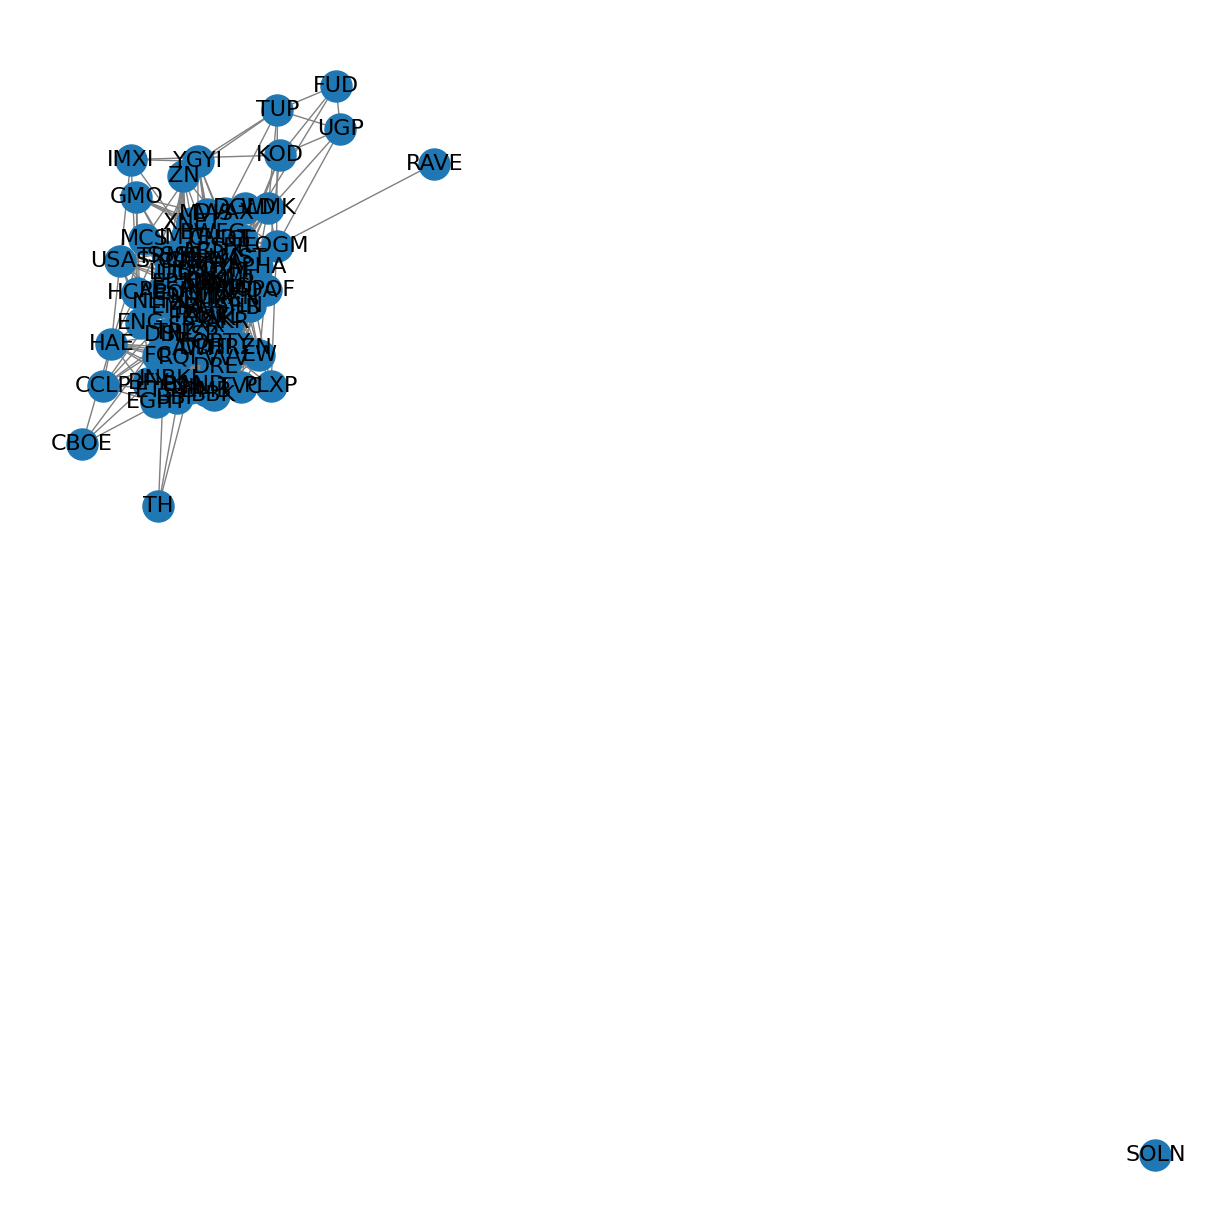

In [174]:
A = np.load("/home/jacob/Documents/finacial-network-analysis/stock_item_adj_matrix.npy")
adj_close_prices = dict(np.load("stock_item_map_small.npz", allow_pickle=True))

print(A.shape)

G = nx.from_numpy_array(A)

plt.figure(figsize=(12,12))
key_enum = list(enumerate(adj_close_prices))

labels = {i: key_enum[i][1] for i in range(len(adj_close_prices))}
pos = nx.spectral_layout(G)
nx.draw(G, labels=labels, with_labels=True, edge_color='gray', node_size=500, font_size=16)
plt.savefig("market_graph.png")

mean degree 30.266666666666666


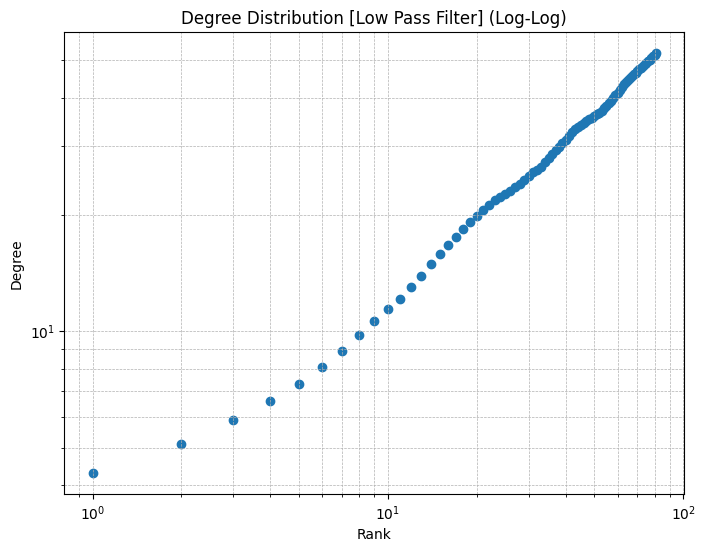

In [175]:
# lets look at the mean degree and do some analysis with the degree distribution

ks = []
for i in A:
    k = np.sum(i)
    ks.append(k)

ks = np.sort(ks)

mean_k = np.mean(ks)
print(f"mean degree {mean_k}")

# Already sorted: ks
window_size = 10  # You can tune this value

# apply a low pass filter
smoothed_ks = np.convolve(ks, np.ones(window_size)/window_size, mode='valid')

ranks = np.arange(1, len(smoothed_ks)+1)
plt.figure(figsize=(8,6))
plt.scatter(ranks, smoothed_ks)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.title('Degree Distribution [Low Pass Filter] (Log-Log)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


Lets take a look at the entropy related to degree distribution. If every node in the network has the same degree then the system is very predictable (low entropy). On the other hand if the degrees are spread out wide then the degree distribution is less predictable (high entropy)

Here we observe that the entropy value for degree distribution is more than 3 which is pretty high. This implies that different items are connected to varying numbers of other items. Also that some items are highly central (influential). High entropy implies the existence of market sectors and volatility driven hubs within the market to be discovered. Theres a lot to be revealed

In [176]:
from scipy.stats import entropy

hist, bins = np.histogram(ks, bins=50, density=True)
hist = hist[hist > 0]  # remove zero bins
degree_entropy = entropy(hist)
print(f"Entropy of degree distribution: {degree_entropy:.4f}")


Entropy of degree distribution: 3.6303


Lets look at the PDF of the degree distribution, whats the probability that a randomly chosen node has degree k

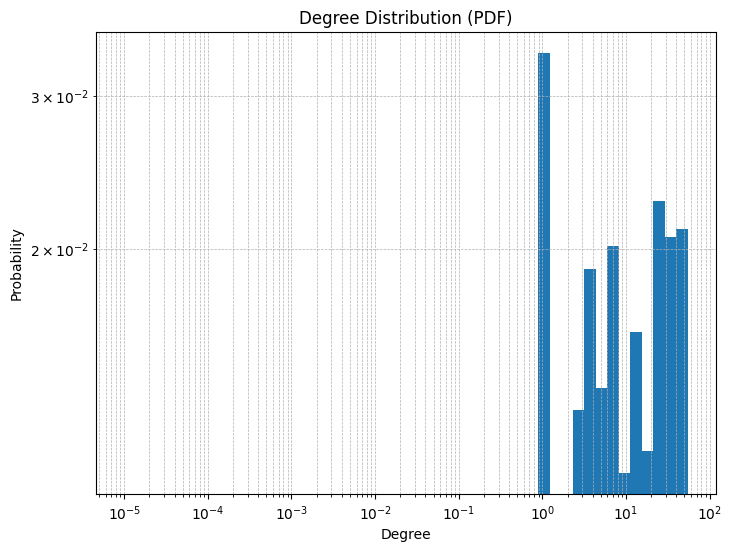

In [177]:
plt.figure(figsize=(8, 6))
plt.hist(ks, bins=np.logspace(np.log10(ks.min()+1e-5), np.log10(ks.max()), 50), density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution (PDF)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


Lets also look at the CCDF, whats the probability that a node has a degree greater or equal to k

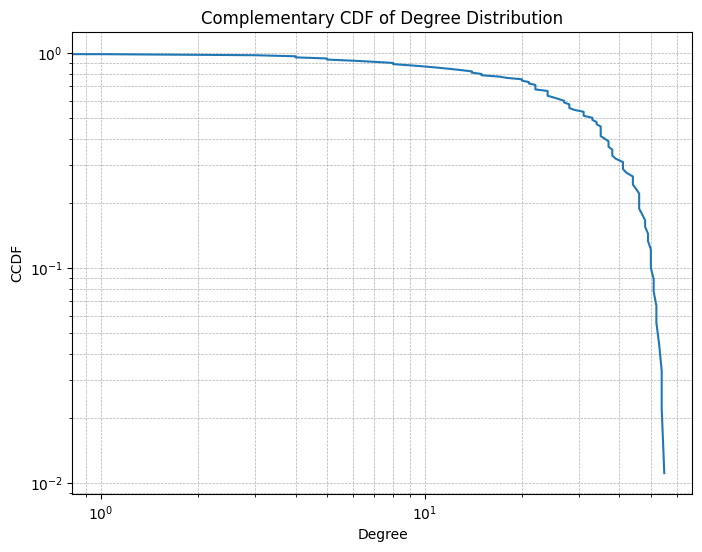

In [178]:
sorted_ks = np.sort(ks)
ccdf = 1.0 - np.arange(len(sorted_ks)) / float(len(sorted_ks))

plt.figure(figsize=(8, 6))
plt.plot(sorted_ks, ccdf)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.title("Complementary CDF of Degree Distribution")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

Lets take a look at some centrality metrics

In [179]:
deg_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

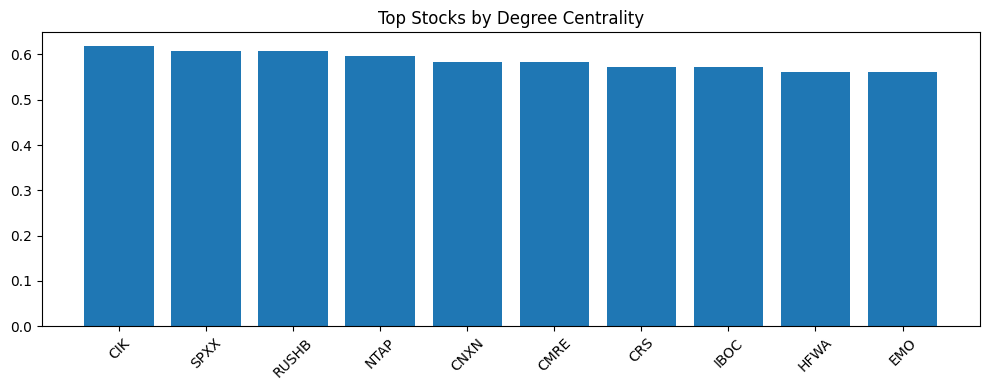

In [180]:
top_k = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{key_enum[i][1]}" for i, _ in top_k]
values = [v for _, v in top_k]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Stocks by Degree Centrality")
plt.tight_layout()
plt.show()

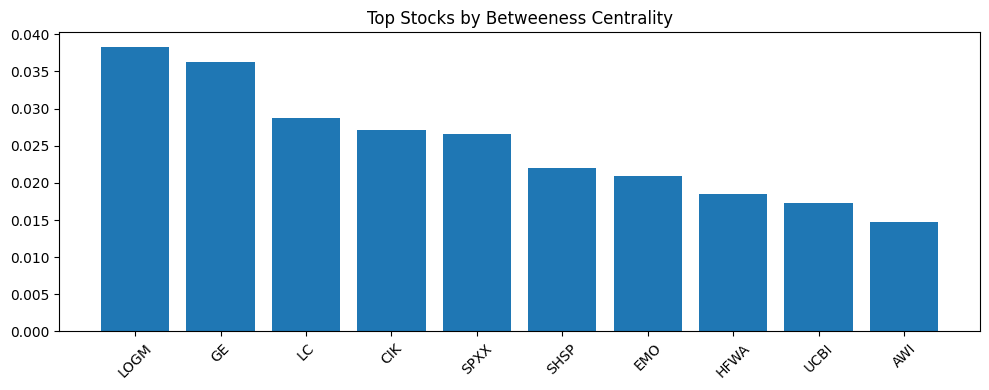

In [181]:
top_k = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{key_enum[i][1]}" for i, _ in top_k]
values = [v for _, v in top_k]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Stocks by Betweeness Centrality")
plt.tight_layout()
plt.show()

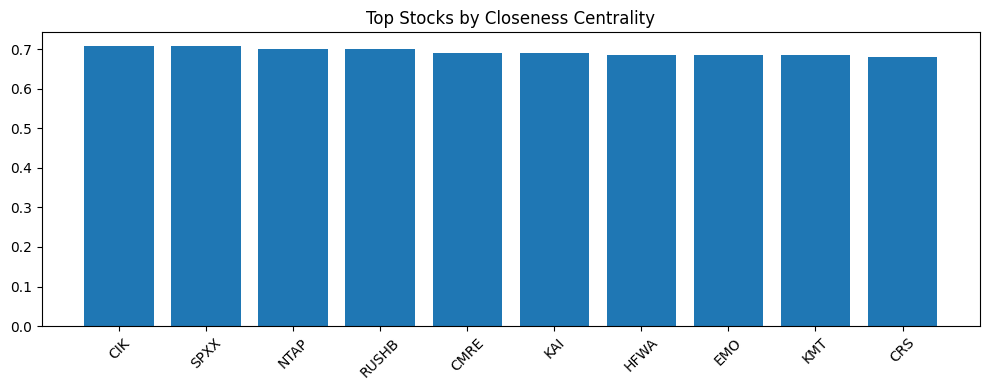

In [182]:
top_k = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{key_enum[i][1]}" for i, _ in top_k]
values = [v for _, v in top_k]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Stocks by Closeness Centrality")
plt.tight_layout()
plt.show()

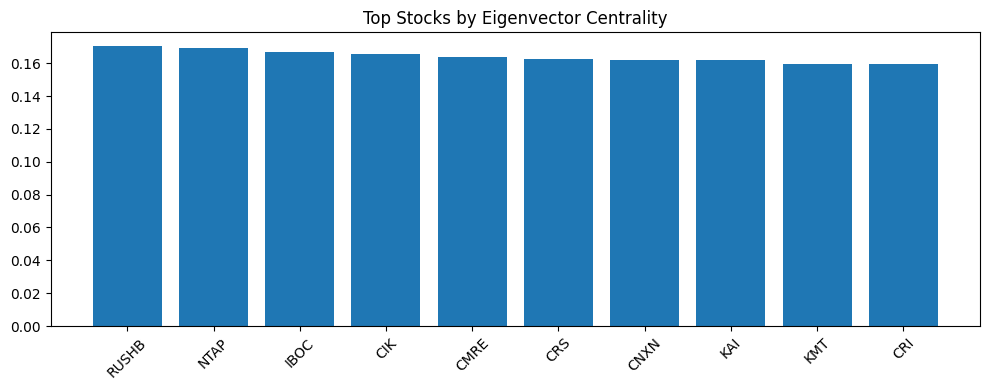

In [183]:
top_k = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{key_enum[i][1]}" for i, _ in top_k]
values = [v for _, v in top_k]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Stocks by Eigenvector Centrality")
plt.tight_layout()
plt.show()

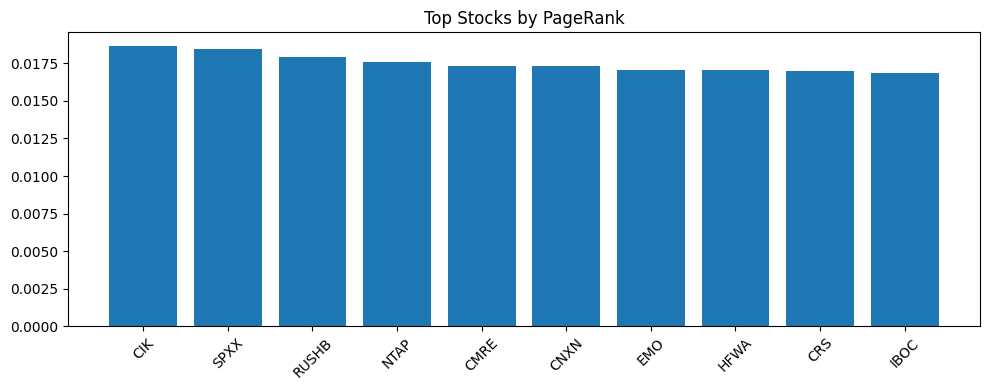

In [184]:
top_k = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{key_enum[i][1]}" for i, _ in top_k]
values = [v for _, v in top_k]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Stocks by PageRank")
plt.tight_layout()
plt.show()

/tmp/ipykernel_26134/4088796319.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("Set1", len(unique_labels))


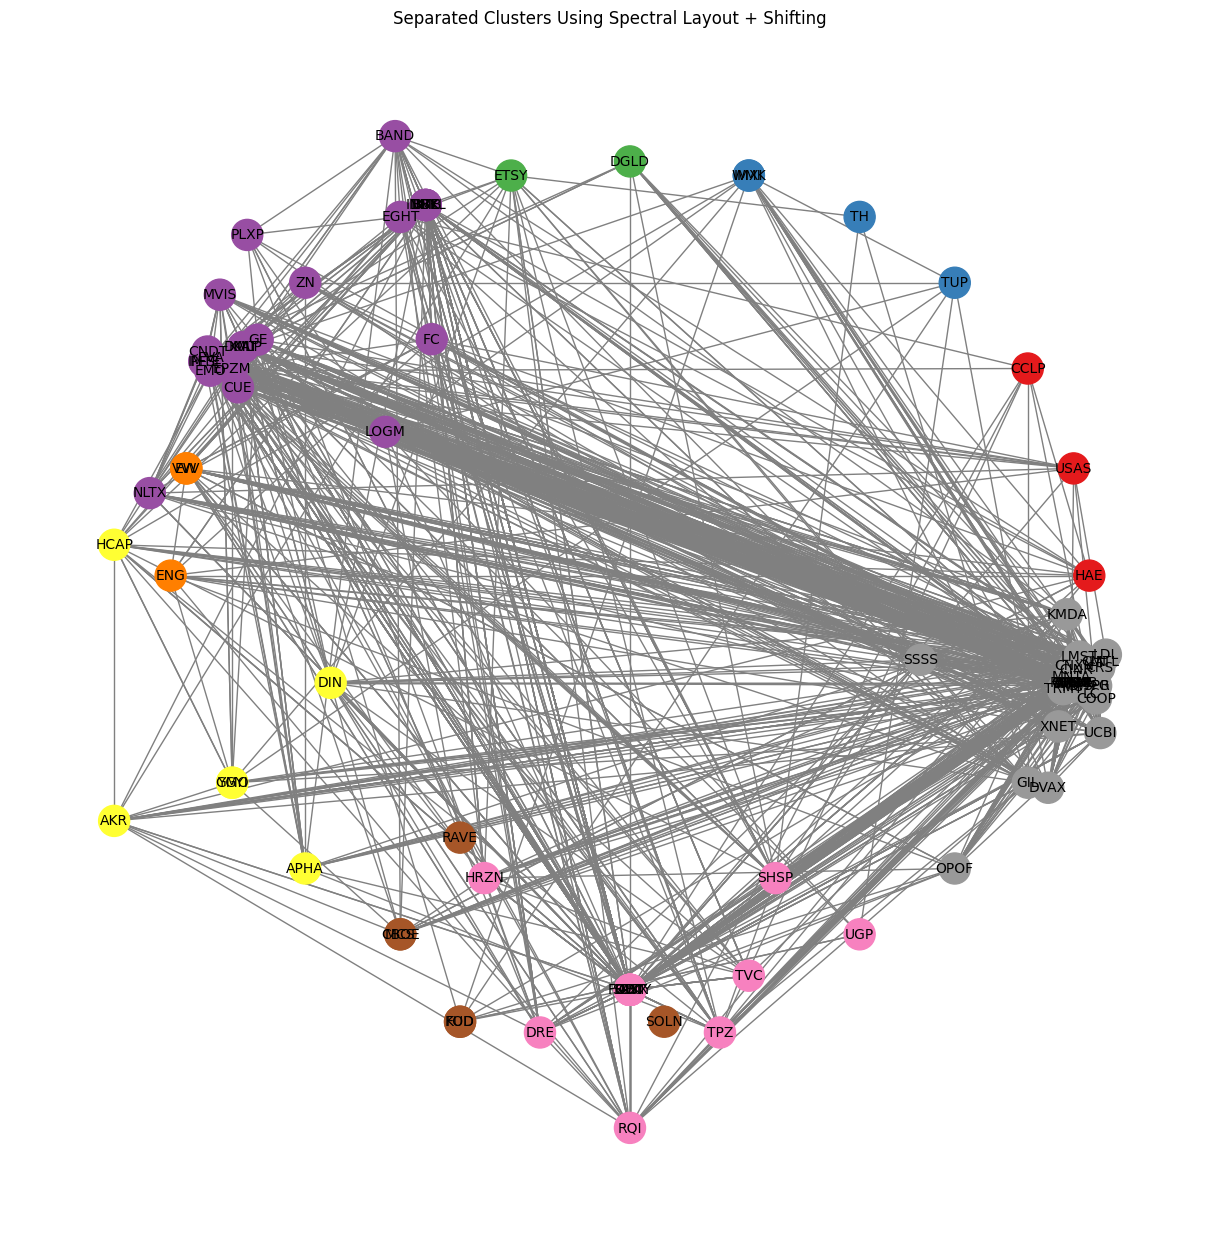

In [185]:
ks = np.sum(A, axis=1)
D = np.diag(ks)
L = D - A
_, U = np.linalg.eigh(L)

def kmeans(X, k, max_iters=1000, tol=1e-5):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels

K = 24 
labels = kmeans(U[:, 1:K+1], K)
unique_labels = np.unique(labels)

# Step 2: Build graph and assign color
G = nx.from_numpy_array(A)
color_map = plt.cm.get_cmap("Set1", len(unique_labels))
node_colors = [color_map(label) for label in labels]

# Step 3: Layout clusters independently and shift them
cluster_nodes = {k: [] for k in unique_labels}
for i, label in enumerate(labels):
    cluster_nodes[label].append(i)

cluster_pos = {}
offset_radius = 3
angle_step = 2 * np.pi / K

for idx, k in enumerate(unique_labels):
    nodes = cluster_nodes[k]
    subgraph = G.subgraph(nodes)
    
    # Layout just this cluster
    local_pos = nx.spectral_layout(subgraph)
    
    # Offset to cluster's position on circle
    angle = idx * angle_step
    offset = np.array([offset_radius * np.cos(angle), offset_radius * np.sin(angle)])
    for node, pos in local_pos.items():
        cluster_pos[node] = pos + offset

# Step 4: Draw
plt.figure(figsize=(12, 12))
node_labels = {i: key_enum[i][1] for i in range(len(adj_close_prices))}
nx.draw(G, pos=cluster_pos, labels=node_labels, with_labels=True,
        node_color=node_colors, edge_color='grey', node_size=500, font_size=10)
plt.title("Separated Clusters Using Spectral Layout + Shifting")
plt.axis('off')
plt.show()


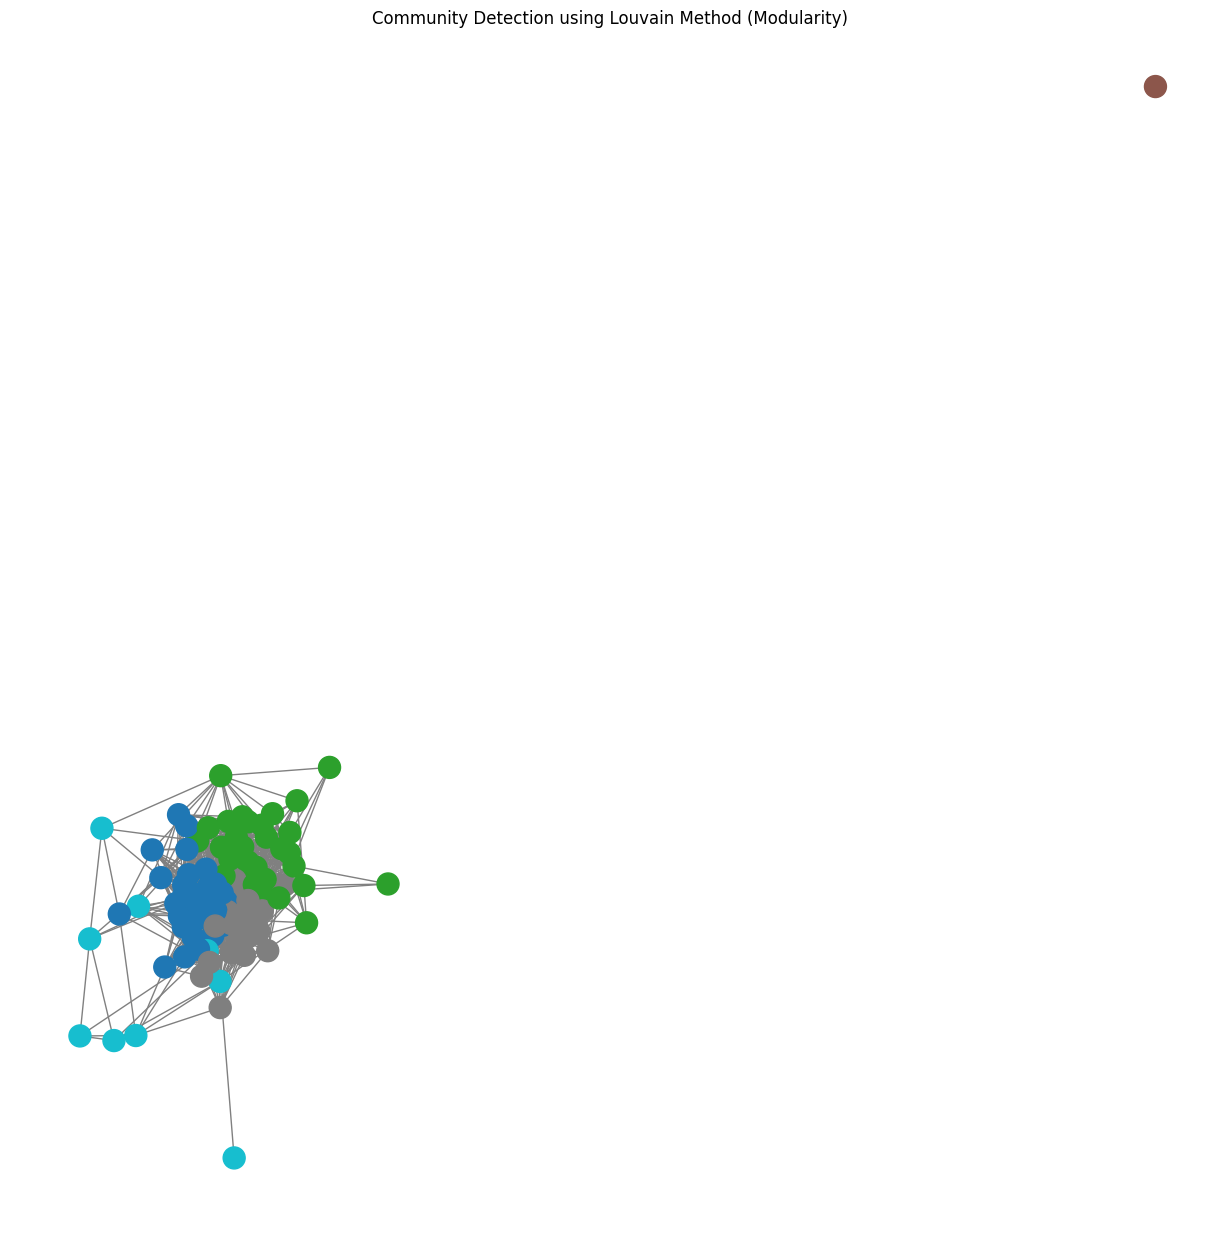

Modularity: 0.173


In [186]:
import community as community_louvain

G = nx.from_numpy_array(A)

partition = community_louvain.best_partition(G)

unique_communities = set(partition.values())
color_map = {node: partition[node] for node in G.nodes()}

colors = [color_map[node] for node in G.nodes()]
pos = nx.spring_layout(G, scale=10) 

plt.figure(figsize=(12, 12))
nx.draw(G, pos, labels=labels, node_color=colors, with_labels=False, node_size=250, edge_color='gray', cmap=plt.cm.tab10)
plt.title("Community Detection using Louvain Method (Modularity)")
plt.show()

communities = [set() for _ in range(max(partition.values()) + 1)]
for node, comm in partition.items():
    communities[comm].add(node)

mod_score = community_louvain.modularity(partition, G)
print(f"Modularity: {mod_score:.3f}")


Lets calculate the minimum spanning tree to identify the underlying market structure

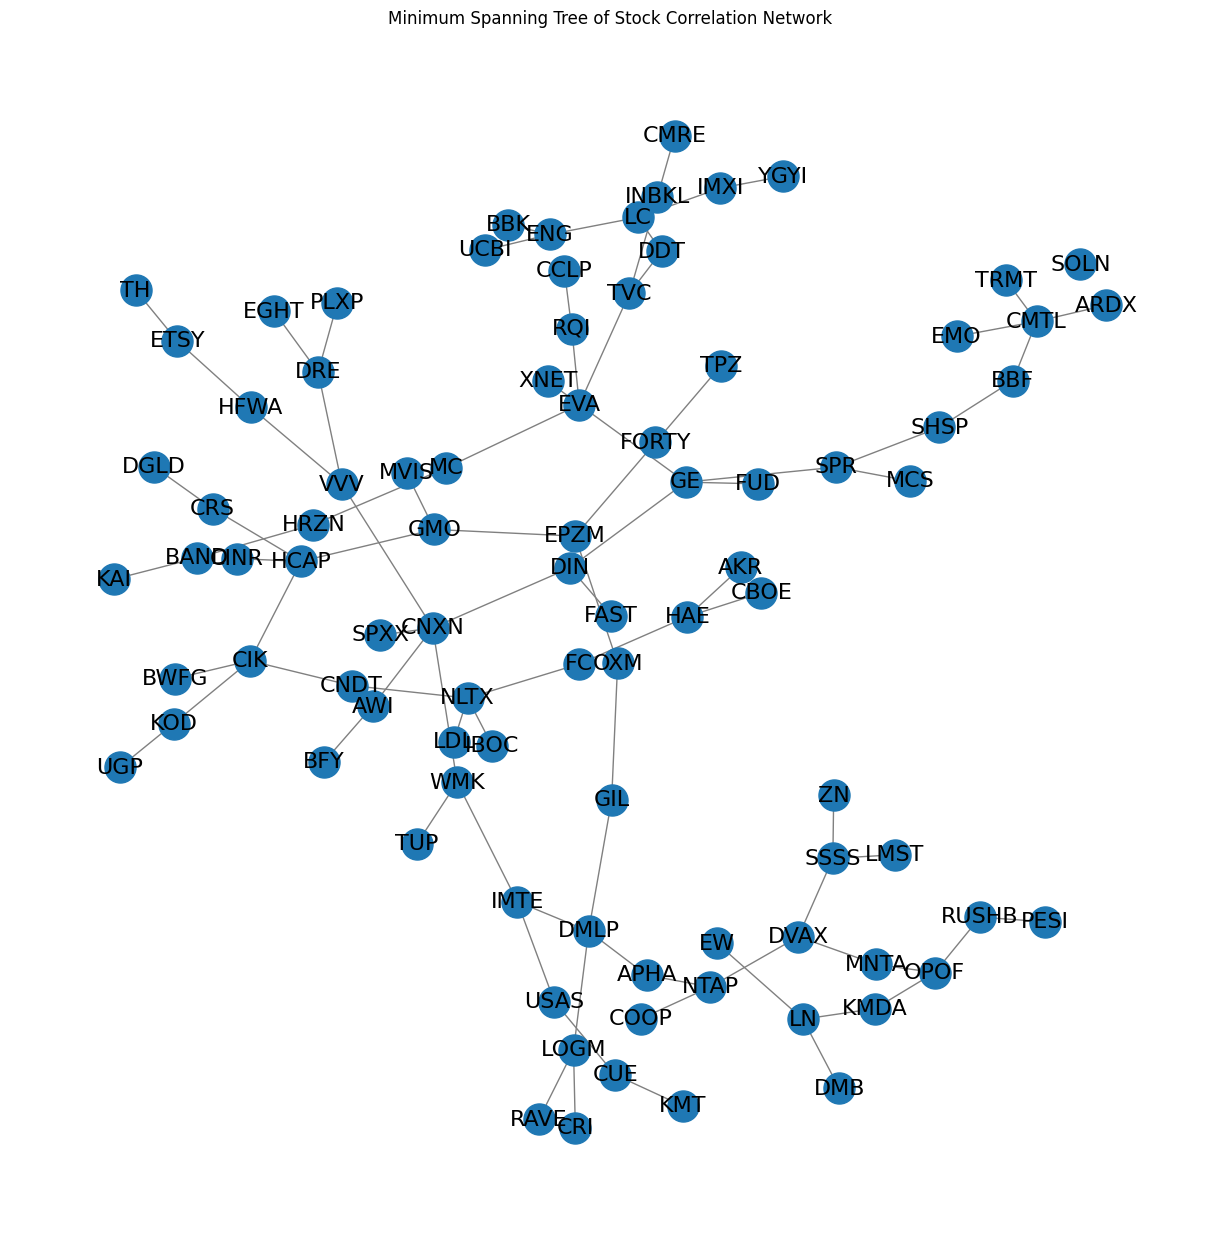

In [192]:
Aw = np.load("stock_item_adj_matrix_weighted.npy")
G = nx.from_numpy_array(Aw)
mst = nx.minimum_spanning_tree(G, weight='weight')

# Visualize MST
pos = nx.spring_layout(mst, seed=42)  # Spring layout gives a decent structure
plt.figure(figsize=(12, 12))

labels = {i: label for i, label in enumerate(adj_close_prices)}
nx.draw(mst, labels=labels, with_labels=True, edge_color='gray', node_size=500, font_size=16)

plt.title("Minimum Spanning Tree of Stock Correlation Network")
plt.show()

https://www.sciencedirect.com/science/article/abs/pii/S0167947304000258